In [6]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import pandas as pd
import numpy as np
import cvxpy as cp
import networkx as nx
import custom_networks
from solution_files_manager import SolutionFilesManager

In [7]:
import os
folder = os.path.abspath(os.getcwd())

## Data processing

In [8]:
case = "ccase3_radial"
case_type = 0
net = custom_networks.ccase3_radial(case_type)

In [9]:
# net = pn.case9()

# # currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
# net.sn_mva = 100

In [10]:
# net = pn.case6ww()

# # currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
# net.sn_mva = 100

No or insufficient geodata available --> Creating artificial coordinates. This may take some time


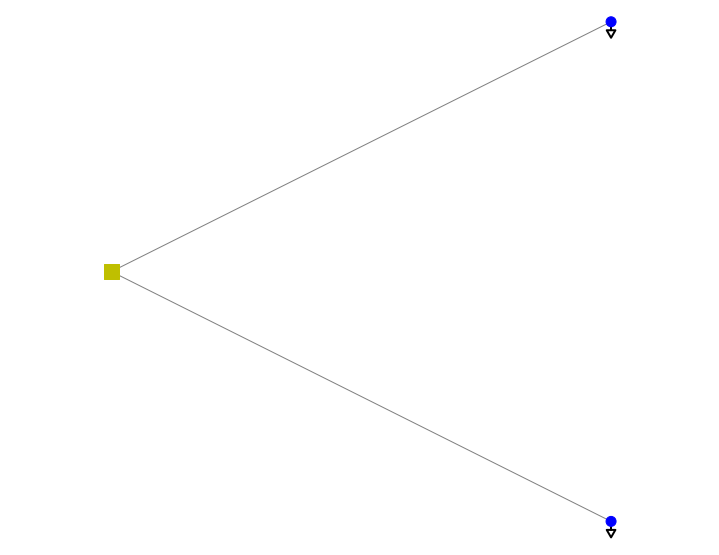

<AxesSubplot:>

In [11]:
simple_plot(net, plot_loads=True, plot_sgens=True)

In [12]:
n = len(net.bus)

#### Generators

In [13]:
gen_df_list = []
gen_name_list = ["gen", "sgen", "ext_grid"]
data_col_list = ["bus", "max_p_mw", "min_p_mw", "max_q_mvar", "min_q_mvar"]

for gen_name in gen_name_list:
    if not net[gen_name].empty:
        # get a table of cost coefficients only for the current type of generators
        gen_name_poly_cost = net.poly_cost.loc[net.poly_cost.et == gen_name].set_index("element")
        # get a table of cost coefficients and power bounds only for the current type of generators
        gen_name_df = net[gen_name][data_col_list].join(gen_name_poly_cost)
        gen_df_list.append(gen_name_df)

# combine tables for all types of generators
gen_df = pd.concat(gen_df_list).reset_index()
n_gen = len(gen_df)

In [14]:
gen_df

,index,bus,max_p_mw,min_p_mw,max_q_mvar,min_q_mvar,et,cp0_eur,cp1_eur_per_mw,cp2_eur_per_mw2,cq0_eur,cq1_eur_per_mvar,cq2_eur_per_mvar2
0,0,0,1.0,0.0,1.0,-1.0,ext_grid,0.0,1.0,0.0,0.0,0.0,0.0


#### Bus loads

In [15]:
load_df = net.bus.join(net.load[["bus", "p_mw", "q_mvar"]].set_index("bus")).fillna(0)[["p_mw", "q_mvar"]]

In [16]:
load_df

,p_mw,q_mvar
0,0.00,0.0
1,0.01,0.0
2,0.01,0.0


#### Admittance matrices

In [17]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

# np.array((net.line['r_ohm_per_km'] * net.line['length_km'] * net.sn_mva * 1e6 / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values * 1e3) ** 2)

In [18]:
G_val = np.zeros((n,n))
B_val = np.zeros((n,n))
for i,j in graph.edges:
    edge = graph.edges[(i,j)]
    r = edge["r_pu"]
    x = edge["x_pu"]
    z = r + x*1j
    y = np.reciprocal(z)
    G_val[i][j] = G_val[j][i] = -np.real(y)
    B_val[i][j] = B_val[j][i] = -np.imag(y)

In [19]:
G_row_sums = np.sum(G_val, axis=1)
B_row_sums = np.sum(B_val, axis=1)
for i in range(n):
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    g = 0  # shunt conductance
    b = 0  # shunt susceptance
    # if both are 0, there will be no data in the shunt dataframe
    if not shunt_row.empty:
        # TODO: figure out how to compute from data
        g = shunt_row["p_mw"].to_numpy()[0]
        b = -shunt_row["q_mvar"].to_numpy()[0]  # FIXME: shunt susceptance is negative as in original data?
    G_val[i][i] = g - G_row_sums[i]
    B_val[i][i] = b - B_row_sums[i]

In [20]:
# obtain a NetworkX Graph from the network, with each edge containing p.u. impedance data
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="pu")

# np.array((net.line['r_ohm_per_km'] * net.line['length_km'] * net.sn_mva * 1e6 / net.line['parallel'])) / ((net.bus.loc[net.line.from_bus.values, "vn_kv"].values * 1e3) ** 2)

In [21]:
graph.edges(data=True)

EdgeDataView([(0, 1, {'key': ('line', 0), 'weight': 1.0, 'path': 1, 'r_pu': 1.0, 'x_pu': 1.0, 'z_pu': 1.4142135623730951}), (0, 2, {'key': ('line', 1), 'weight': 1.0, 'path': 1, 'r_pu': 1.0, 'x_pu': 1.0, 'z_pu': 1.4142135623730951})])

## Variables

In [22]:
# X = VV*
X = cp.Variable((n,n), hermitian=True)
# active power generated
p_g = cp.Variable((n_gen, 1))
# reactive power generated
q_g = cp.Variable((n_gen, 1))

## Parameters

In [23]:
p_d_val = load_df[["p_mw"]].to_numpy() / net.sn_mva
q_d_val = load_df[["q_mvar"]].to_numpy() / net.sn_mva

In [24]:
# loads
p_d = cp.Parameter((n,1), nonneg=True, value=p_d_val)
q_d = cp.Parameter((n,1), nonneg=True, value=q_d_val)

# admittance matrices
G = cp.Parameter((n,n), symmetric=True, value=G_val)
B = cp.Parameter((n,n), symmetric=True, value=B_val)

# squares of voltage bounds
V_min_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["min_vm_pu"].to_numpy()))
V_max_sq = cp.Parameter((n), nonneg=True, value=np.square(net.bus["max_vm_pu"].to_numpy()))

# bounds for generated power
p_min = cp.Parameter((n_gen,1), value=gen_df[["min_p_mw"]].to_numpy() / net.sn_mva)
p_max = cp.Parameter((n_gen,1), value=gen_df[["max_p_mw"]].to_numpy() / net.sn_mva)
q_min = cp.Parameter((n_gen,1), value=gen_df[["min_q_mvar"]].to_numpy() / net.sn_mva)
q_max = cp.Parameter((n_gen,1), value=gen_df[["max_q_mvar"]].to_numpy() / net.sn_mva)

In [25]:
# vectors of cost coefficients: c_[p or q]_[power]

c_p_2 = cp.Parameter((n_gen), value=gen_df["cp2_eur_per_mw2"].to_numpy(), nonneg=True)
c_p_1 = cp.Parameter((n_gen), value=gen_df["cp1_eur_per_mw"].to_numpy(), nonneg=True)
c_p_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

c_q_2 = cp.Parameter((n_gen), value=gen_df["cq2_eur_per_mvar2"].to_numpy(), nonneg=True)
c_q_1 = cp.Parameter((n_gen), value=gen_df["cq1_eur_per_mvar"].to_numpy(), nonneg=True)
c_q_0 = cp.Parameter((n_gen), value=gen_df["cp0_eur"].to_numpy(), nonneg=True)

## Constraints

In [26]:
constraints = [X >> 0]

In [27]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    constraints += [
        cp.sum([p_g[k] for k in gen_list]) - p_d[i] == G[i][i] * X[i][i] +
        cp.sum([G[i][j] * cp.real(X[i][j]) + B[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]
    constraints += [
        cp.sum([q_g[k] for k in gen_list]) - q_d[i] == -B[i][i] * X[i][i] +
        cp.sum([-B[i][j] * cp.real(X[i][j]) + G[i][j] * cp.imag(X[i][j]) for j in graph.neighbors(i)])
    ]

In [28]:
constraints += [
    cp.real(cp.diag(X)) >= V_min_sq,
    cp.real(cp.diag(X)) <= V_max_sq
]

In [29]:
constraints += [ X[0][0] == 1 ]

In [30]:
constraints += [
    p_g >= p_min,
    p_g <= p_max,
    q_g >= q_min,
    q_g <= q_max
]

## Solving

In [31]:
p_cost = cp.sum(c_p_2 @ cp.square(p_g) + c_p_1 @ p_g + c_p_0)
q_cost = cp.sum(c_q_2 @ cp.square(q_g) + c_q_1 @ q_g + c_q_0)

In [32]:
prob = cp.Problem(cp.Minimize(p_cost + q_cost), constraints)

In [33]:
prob.is_dcp()

True

In [34]:
prob.is_dpp()

True

In [35]:
prob.solve()

# Print result.
print("The optimal value is", prob.value)
# print("A solution X is")
# print(X.value)

The optimal value is 0.020204123008640353


In [36]:
np.abs(np.linalg.eigvalsh(X.value))

array([6.00553941e-10, 7.21339100e-10, 2.95959175e+00])

In [37]:
print(p_g.value)
print(q_g.value)

[[0.02020412]]
[[0.00020412]]


In [38]:
prob.status

'optimal'

In [ ]:
# sfm = SolutionFilesManager(folder, case, case_type, "sdp")
# sfm.save_solution(prob.value, X, p_g, q_g)

### Verify constraints with original solution

In [60]:
sfm = SolutionFilesManager(folder, case, case_type, "orig")
_, V_orig, p_orig, q_orig = sfm.load_solution()

In [61]:
X_orig = V_orig @ V_orig.conjugate().reshape(1,-1)

In [62]:
for i in range(n):
    gen_list = gen_df.loc[gen_df["bus"] == i].index.to_numpy()
    print("active %d"  %(i))
    print(np.sum([p_orig[k] for k in gen_list]) - p_d_val[i])
    print(G_val[i][i] * X_orig[i][i] + np.sum([G_val[i][j] * np.real(X_orig[i][j]) + B_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))
    print("reactive %d"  %(i))
    print(np.sum([q_orig[k] for k in gen_list]) - q_d_val[i])
    print(-B_val[i][i] * X_orig[i][i] + np.sum([-B_val[i][j] * np.real(X_orig[i][j]) + G_val[i][j] * np.imag(X_orig[i][j]) for j in graph.neighbors(i)]))

active 0
[0.02020412]
(0.02020412413215711+0j)
reactive 0
[0.00020412]
(0.00020412414104953314+0j)
active 1
[-0.01]
(-0.009999999991285868+0j)
reactive 1
[0.]
(4.267919351264027e-12+0j)
active 2
[-0.01]
(-0.009999999991285868+0j)
reactive 2
[0.]
(4.267919351264027e-12+0j)
